# Workspace for e-chemistry 
Version (10.07.2023)
This workspace is dedicated to e-chemistry, providing analysis tools for CP, CA, and CV. Please note that these tools are specifically designed to work with a particular file format.

The CP class is developed and maintained by the Elias Klemm group at the University of Stuttgart. For CA and CV analysis, you can utilize the projects from the Kristina Tschulik group at the University of Bochum and the Biprajit Sarkar group at the University of Stuttgart.

# Packages for the Analysis tools

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import copy
from scipy.optimize import curve_fit
from sdRDM import DataModel
from tabulate import tabulate
from scipy.integrate import trapz
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


################################################################
#imports the Analysis tools from the subfolder functions. They are in a Py file called Analysis
from functions.Analysis import ReferenceCalculator,Chronopotentiometry,Chronoamperometry

# Creation of the subfolders data and plots
By exicuting the following cell two subfolder were created called data and plots. In the data folder you can store your measurement data and the plot folder is the folder were your plots get created. 

In [ ]:
path_program=os.getcwd()
data="/data"
plots="/plots"

path_data= path_program + data

path_plots=path_program+ plots
if not os.path.exists(path_data):
    os.makedirs(path_data)
if not os.path.exists(path_plots):
    os.makedirs(path_plots)


# Datamodel from GitHub
The following cell loads the Datamodel from GitHub and stores it in the variable lib.

In [2]:

lib = DataModel.from_markdown("specifications/Electrochemistry.md")
#lib=DataModel.from_git(url="https://github.com/FAIRChemistry/datamodel-electrochemistry.git")
e_chem=lib.Dataset()



# Data formats
## Chronopotentiometry
The Chronopotentiometry class works with the formats: 
- .DTA 
## Chronoamperometry 
The Chronoamperometry class accepts the formats:
- .csv (group Tschulik)
- .dat (group Tschulik)
- .txt (group Sarkar)
### Cyclic Voltammetry 
The CyclicVoltammetry class accepts the formats:
- .csv (group Tschulik & Sarkar)
- .xlsx (group Sarkar)
  
Please note that the CSV file needs to be saved in UTF-8 format. To ensure this, open the CSV file in an editor like Excel and save it as a UTF-8 CSV file. This step is necessary to properly handle special characters and encoding. However, this encoding consideration is not required for XLSX files.

Unlike CSV files, XLSX files do not require specific encoding considerations. They inherently support a wider range of characters, including special characters, without the need for explicit encoding settings. Additionally, the data parser for XLSX files often works faster due to its utilization of the "C" engine.

In [4]:
"""The following shows ho to store experiments into the list of experiments"""
experiment0=lib.Experiment(name="Cu 12 nm",filename="data/Cu12nm.DTA",type=lib.enums.Experiment_type.CP.value)
experiment1=lib.Experiment(name="Cu 14 nm",filename="data/Cu14nm.DTA",type=lib.enums.Experiment_type.CP.value)
experiment2=lib.Experiment(name="CA1",filename="data/CA1.dat",type=lib.enums.Experiment_type.CA.value)
experiment3=lib.Experiment(name="CA_Sarkar",filename="data/CA_Sarkar.txt",type=lib.enums.Experiment_type.CA.value)
experiment4=lib.Experiment(name="CV",filename="data/SarkarCV_utf8.csv",type=lib.enums.Experiment_type.CV.value)
experiment5=lib.Experiment(name="CV",filename="data/CV_all2.xlsx",type=lib.enums.Experiment_type.CV.value)
experiment6=lib.Experiment(name="CV",filename="data/CV_all.xlsx",type=lib.enums.Experiment_type.CV.value)
experiment7=lib.Experiment(name="Re Complex",filename="data/Ox_100mVs.csv",type=lib.enums.Experiment_type.CV.value)
experiment8=lib.Experiment(name="Fc",filename="data/Ref_Fc_100mVs.csv",type=lib.enums.Experiment_type.CV.value)
e_chem.experiments=[experiment0,experiment1,experiment2,experiment3,experiment4,experiment5,experiment6,experiment7,experiment8]
#### CP
e_chem.experiments[0].electrode_setup=lib.ElectrodeSetup(counter_electrode="Pt",reference_electrode="Hg/HgO",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value,working_electrode="Au",working_electrode_area=1,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM)
e_chem.experiments[1].electrode_setup=lib.ElectrodeSetup(counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value,working_electrode="Au",working_electrode_area=1,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM)
e_chem.experiments[0].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[1].electrolyte=lib.Electrolyte(solvent="MeCN",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[0].analysis=lib.Analysis(cp=lib.CP(induced_current=[200],induced_current_unit="mA",measurement_potential_unit="V",measurement_time_unit="s"))
e_chem.experiments[1].analysis=lib.Analysis(cp=lib.CP(induced_current=[200],induced_current_unit="mA",measurement_potential_unit="V",measurement_time_unit="s"))
#### CA
e_chem.experiments[2].electrode_setup=lib.ElectrodeSetup(working_electrode_area=1,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM,counter_electrode="Pt",reference_electrode="Hg/HgO",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[3].electrode_setup=lib.ElectrodeSetup(working_electrode_area=1,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM,counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[2].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[3].electrolyte=lib.Electrolyte(solvent="MeCN",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[2].analysis=lib.Analysis(ca=lib.CA(induced_potential=[20],induced_potential_unit="V",measurement_current_unit="A",measurement_time_unit="s"))
e_chem.experiments[3].analysis=lib.Analysis(ca=lib.CA(induced_potential=[20],induced_potential_unit="V",measurement_current_unit="A",measurement_time_unit="s"))
#### CV
e_chem.experiments[4].electrode_setup=lib.ElectrodeSetup(working_electrode="Au",working_electrode_area=2,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM,counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[4].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[4].analysis=lib.Analysis(cv=lib.CV(scan_rate=20,scan_rate_unit="mV/s"))
e_chem.experiments[5].electrode_setup=lib.ElectrodeSetup(working_electrode="Au",working_electrode_area=2,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM,counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[5].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[5].analysis=lib.Analysis(cv=lib.CV(scan_rate=20,scan_rate_unit="mV/s"))
e_chem.experiments[6].electrode_setup=lib.ElectrodeSetup(working_electrode="Au",working_electrode_area=2,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM,counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[6].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[6].analysis=lib.Analysis(cv=lib.CV(scan_rate=20,scan_rate_unit="mV/s"))
e_chem.experiments[7].electrode_setup=lib.ElectrodeSetup(working_electrode="Au",working_electrode_area=2,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM,counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[7].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[7].analysis=lib.Analysis(cv=lib.CV(scan_rate=100,scan_rate_unit="mV/s"))
e_chem.experiments[8].electrode_setup=lib.ElectrodeSetup(working_electrode="Au",working_electrode_area=2,working_electrode_area_unit=lib.enums.AreaUnits.SQUARE_CM,counter_electrode="Pt",reference_electrode="Ag/AgCl",reference_electrode_salt="KCl",reference_electrode_salt_concentration=1,reference_electrode_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR.value)
e_chem.experiments[8].electrolyte=lib.Electrolyte(solvent="H$_2$O",conducting_salt="KOH",conducting_salt_concentration=1,conducting_salt_concentration_unit=lib.enums.ConcentrationUnits.MOLAR,pH=10)
e_chem.experiments[8].analysis=lib.Analysis(cv=lib.CV(scan_rate=100,scan_rate_unit="mV/s"))

# Change the style and parameter of the plots
The following cell is not needed only if you want to change some parameters of your plots

In [9]:
plt.rcParams.update({
    'figure.figsize': (6.4,4.8),     # 4:3 aspect ratio. You can change the figure size here
    'font.size' : 12,                   # Set font size to 12pt
    'axes.labelsize': 12,               # -> axis labels
    'legend.fontsize': 12,              # -> legends
    'font.family': 'serif',             # -> font family  
    'font.sans-serif': 'Times New Roman',
    'text.usetex': False,              # Latex plot rendering. If True,your plots will be rendered with Latex. But this needs extra time for rendering
     'text.latex.preamble':            # LaTeX preamble
         r'\usepackage{mathptmx}'
         #... more packages if needed
})
####################
""" Here u can also use an other matplotlib style, like ggplot"""
#plt.style.use('ggplot') # You can choose ure matplotlib style

# If you prefere plotstyle like Origin use the following code:

In [18]:
##### """" For Plotstyle like Origin:
from matplotlib import  cycler
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'Verdana', 'DejaVu Sans']
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 1.1
plt.rcParams['axes.labelpad'] = 5.0
plot_color_cycle = cycler('color', [ '0000FE', 'FE0000', '008001', 'FD8000', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf','000000'])
plt.rcParams['axes.prop_cycle'] = plot_color_cycle


# Analytic tools
## ReferenceCalculator class 
The ReferenceCalculator class includes a list of different reference potentials and a reference_difference function. This can be used to calculate the difference between two reference potentials. The reference_difference function is an interactive calculator.

In [5]:
calculator=ReferenceCalculator()
calculator.reference_list()
calculator.reference_difference()

Reference              Potential (V)
-------------------  ---------------
SHE                           0
RHE                          -0.0592
Calomel (sat. KCl)            0.241
Calomel (3.5 M KCl)           0.25
Calomel (1 M KCl)             0.28
Calomel (0.1 M KCl)           0.334
Ag/AgCl (sat. KCl)            0.199
Ag/AgCl (3.5 M KCl)           0.205
Hg/HgO (1 M KOH)              0.14
Hg/HgO (0.1 M KOH)            0.165
Fc/Fc+                        0.4


interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

### Chronopotentiometry(experiment_list,add_potential_value=None,new_reference_name=None,change_reference=False)
This class specifically requires a list of Chronopotentiometry experiments as input. For example, you can pass in [0, 1] to indicate using the first and second experiments that you defined earlier. By setting change_reference=True and specifying a value in add_potential_value, you can conveniently adjust your reference and perform calculations in the new reference scale. Additionally, you have the option to customize the label of your y-axis by defining new_reference_name. It's important to note that this functionality only works when change_reference=True.

The CP class has the following functions:
- quick_plot() -> shows all relevant data: $E$ vs time, $I$ vs. time and $E$ of the mess cell vs time. It is only to check if your data looks good or not
- plot() -> return a plot $E$ vs time. 
- end_value()
- end_value_fit()

To determine the last potential, you have two options:

Using end_value(): This function returns the average of the last 75 values of your measurement by default. However, you can also specify a different range, up to the last 200 values, based on your choice. This method is suitable for general measurements.

Using end_value_fit(): This alternative method determines the last potential through a fit function. It can be particularly useful for handling oscillating measurement data or cases where a fit provides a more accurate representation of the last potential.

By utilizing either end_value() or end_value_fit(), you can determine the last potential in your measurement based on your specific needs and the characteristics of your data.

# ChronoAmperometry class/ ChronoAmperometry(metadata,current_density=False)
This class is very similar to the ChronoPotentiometry class it has the same input but another attribute current_density=False. By setting this on True you will be able to work with the current density instead of the current.

The CA class has the following functions:
- plot(save=False,label=False) -> return a plot $I$ vs time. It can be saved by setting save=True. The x and y labels can also be changed with label=True
- end_value()
- end_value_fit()

# CyclicVoltammetry class
## CyclicVoltammetry(metadata,[cycles]=None,change_reference=False,current_density=False)
The CyclicVoltammetry class is for Cyclic Voltammetry and needs also a metadata as input. An optional input are the cycles as a list. If you don't give a cycle as input then all cycles will be used. It has also the change_reference and current_density attributes as previously mentioned. The functions are:
- plot(legendposition(x,y),save=False,label=False)
- peaks(range=None) # By default it will be used the whole electrochemical windows, but you can put a range here.
- integration() # This integrates the for- and back cycle separately


# CV Interactive

# CV Datamodel

In [14]:

class CyclicVoltammetry:
    def __init__(self,experiment,e_chem=e_chem,cycles=None,add_potential_value=None,new_reference_name=None,current_density=False,change_reference=False):
        if e_chem.experiments[experiment].type=="CV"  and e_chem.experiments[experiment].filename.endswith(".csv"):
            self.df = pd.read_csv(e_chem.experiments[experiment].filename,header=5,skipfooter=1,engine="python")#
        elif e_chem.experiments[experiment].type=="CV"  and e_chem.experiments[experiment].filename.endswith(".xlsx"):
            self.df=pd.read_excel(e_chem.experiments[experiment].filename,header=1)
        else:
            print("This is not a CV data")  
        self.total_cycles=len(self.df.columns) // 2
        self.all_cycles_list= [i for i in range(1,self.total_cycles+1)]
        self.cycles= cycles if cycles is not None else self.all_cycles_list
        self.electrolyte= f"{e_chem.experiments[experiment].electrolyte.conducting_salt_concentration}  {e_chem.experiments[experiment].electrolyte.conducting_salt_concentration_unit} {e_chem.experiments[experiment].electrolyte.conducting_salt}  {e_chem.experiments[experiment].electrolyte.solvent}"
        self.name= e_chem.experiments[experiment].name 
        self.substrate= e_chem.experiments[experiment].electrode_setup.working_electrode
        self.scan_rate= f"{e_chem.experiments[experiment].analysis.cv.scan_rate} {e_chem.experiments[experiment].analysis.cv.scan_rate_unit}"
        self.reference = e_chem.experiments[experiment].electrode_setup.reference_electrode if e_chem.experiments[experiment].electrode_setup.reference_electrode is not None else "Ag/AgCl"
        mapping_dict={"cm^2":"cm$^2$",
                      "mm^2":"mm$^2$"}
        area_unit=mapping_dict[e_chem.experiments[experiment].electrode_setup.working_electrode_area_unit]
        self.E = ["E" for i in range(self.total_cycles)]
        self.I = ["I" for i in range(self.total_cycles)]
        self.df.columns = [name for pair in zip(self.E, self.I) for name in pair]
        self.num_cycles = int(self.df.shape[1] / 2)
        self.cycle_df = np.array_split(self.df, self.num_cycles, axis=1)
        self.cycles = [cycle -1 for cycle in self.cycles]
        self.experiment=experiment
        new_reference_name=new_reference_name if new_reference_name is not None else "Fc/Fc$^{+}$"
        if change_reference:
            delta_E=add_potential_value
            self.reference=new_reference_name
            for df in self.cycle_df:
                df['E'] = df['E'] + delta_E
        self.xlabel= f"$E$ vs. {self.reference}  (V)"
        self.ylabel= r"$I$  ($\mathrm{\mu}$A)" ### \textmu if latex rendering
        if current_density:
            self.ylabel=f"$J$ ($\mathrm{{\mu}}$A / {area_unit})"
            for df in self.cycle_df:
                df["I"] = df["I"] / e_chem.experiments[experiment].electrode_setup.working_electrode_area
    def plot(self):
        xlabel=self.xlabel
        ylabel=self.ylabel
        if e_chem.experiments[self.experiment].electrolyte.solvent=="H$_2$O":
            annotate_text=f"{self.electrolyte}/pH={e_chem.experiments[self.experiment].electrolyte.pH}/{self.substrate}\n$v$={self.scan_rate}"
        else:
            annotate_text=f"{self.electrolyte}/{self.substrate}\n$v$={self.scan_rate}"
        def interactive(xlabel=xlabel, ylabel=ylabel,savename="CV_plot.pdf",text_xcoord=0.7,text_ycoord=0.05,annotate_text=widgets.Textarea(value=annotate_text),save=False,annotate=True,legend=True,arrow=True,y_arrow_position=self.cycle_df[0]['I'][0]+2,arrow_end=15): #
            fig, ax = plt.subplots()
            for i in self.cycles: 
                ax.plot(self.cycle_df[i]["E"],self.cycle_df[i]["I"],label="Cycle: {}".format(i+1))
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
            if legend:
                ax.legend(loc="best",frameon=False)
           
            if annotate:
                ax.annotate(annotate_text, xy=(text_xcoord,text_ycoord), xycoords="axes fraction")
            if arrow:
                self.cycle_df[0]['E'] = self.cycle_df[0]['E'].astype(float)
                self.cycle_df[0]['I'] = self.cycle_df[0]['I'].astype(float)
                ax.arrow(self.cycle_df[0]['E'][0],y_arrow_position, dx=self.cycle_df[0]['E'][arrow_end]-self.cycle_df[0]['E'][0], dy=0, head_width=(self.cycle_df[0]['I'].max()--self.cycle_df[0]['I'].min())/10, head_length=(self.cycle_df[0]['E'].max()-self.cycle_df[0]['E'].min())/12, fc='black', ec='black')
            if save:
                fig.savefig("plots/" + savename,bbox_inches='tight')
        widgets.interact(interactive,text_xcoord=(0,1.2,0.05),text_ycoord=(0,1.2,0.05),y_arrow_position=(self.cycle_df[0]['I'].min(),self.cycle_df[0]['I'].max()),arrow_end=(1,100,1))
    def peaks(self):
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        xlabel=self.xlabel
        ylabel=self.ylabel
        def interactive(E_Min=x_min,E_Max=x_max,vertex_line=False, E_hwp_average=False,savename="CV_peaks.pdf",save=False): 
            E_min=[]
            E_max=[]
            E_hwp=[]
            E_hwp_mean=[]
            Cycles=[]
            I_max=[]
            I_min=[]
            I_vertex_list=[]
            for i in self.cycles:
                fig, ax=plt.subplots()
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.plot(self.cycle_df[i]["E"],self.cycle_df[i]["I"],label="Cycle: {}".format(i+1))
                Cycles.append("Cycle: {}".format(i+1))
                indices = np.where((self.cycle_df[i]["E"] >= E_Min) & (self.cycle_df[i]["E"] <= E_Max))[0]
                max_index = indices[np.argmax(self.cycle_df[i]["I"][indices])]
                pot_at_max = self.cycle_df[i]["E"][max_index]
                current_at_max = self.cycle_df[i]["I"][max_index]
                min_index = indices[np.argmin(self.cycle_df[i]["I"][indices])]
                pot_at_min = self.cycle_df[i]["E"][min_index]
                current_at_min = self.cycle_df[i]["I"][min_index]
                max_E= np.argmax(self.cycle_df[i]["E"])
                min_E= np.argmin(self.cycle_df[i]["E"])
                I_at_max_E=self.cycle_df[i]["I"][max_E]
                I_at_min_E=self.cycle_df[i]["I"][min_E]
                I_start=self.cycle_df[i]["I"][0]
                ax.axvline(x=(pot_at_max+pot_at_min)/2 , color='red', linestyle='--',linewidth=2)
                ax.axvline(x=pot_at_min , color='darkgreen', linestyle=':',linewidth=2)
                ax.axvline(x=pot_at_max , color='orange', linestyle=':')
                ax.legend(frameon=False)
                if self.cycle_df[0]["E"][0]< self.cycle_df[0]["E"][10]:
                    I_vertex=I_at_max_E
                else:
                    I_vertex=I_at_min_E
                E_max.append(pot_at_max)
                E_min.append(pot_at_min)
                E_hwp.append((pot_at_max+pot_at_min)/2 )
                average_hwp = np.average(E_hwp)
                I_min.append(current_at_min)
                I_max.append(current_at_max)
                I_vertex_list.append(I_vertex)
                if vertex_line:
                    ax.axhline(y=I_vertex , color='black', linestyle='-')
            if E_hwp_average:
                print(average_hwp)
            self.df_peaks = pd.DataFrame(list(zip(Cycles,E_min,I_min,E_max,I_max,E_hwp,I_vertex_list)), columns=["Cycles",'E_at_min',"I min",'E_at_max',"I max","E1/2","I_vertex"])  
            if save:
                fig.savefig("plots/" +"Cycle{}_".format(i+1)+savename)

            return self.df_peaks
        widgets.interact(interactive,E_Min=(x_min,x_max),E_Max=(x_min,x_max))
        
        return 
    def integration(self):
        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        xlabel=self.xlabel
        ylabel=self.ylabel
        def interactive(E_min=(x_min-0.1,x_max,0.01),E_max=(x_min,x_max,0.01),E_min_back=(x_min-0.1,x_max,0.01),E_max_back=(x_min,x_max,0.01),savename="integration_plot.pdf",save=False):
            Cycles=[]
            Integral_forward=[]
            Integral_backward=[]
            for i in self.cycles:
                    Cycles.append("Cycle: {}".format(i+1)) 
                    fig,ax=plt.subplots()
                    df=self.cycle_df[i]
                    half= len(df)//2
                    forward_cycle=df.iloc[:half,:]
                    backward_cycle=df.iloc[half:,:]
                    forward_cycle_peak = forward_cycle[(forward_cycle['E'] >= E_min) & (forward_cycle['E'] <= E_max)]
                    #new regression
                    start_value = forward_cycle_peak.iloc[0]['E']
                    end_value = forward_cycle_peak.iloc[-1]['E']
                    forward_slope = (forward_cycle_peak.iloc[-1]['I'] - forward_cycle_peak.iloc[0]['I']) / (end_value - start_value)
                    intercept = forward_cycle_peak.iloc[0]['I'] - forward_slope * start_value
                    def line_func(x):
                        return forward_slope * x + intercept
                    y_pred1 = line_func(forward_cycle_peak['E'].values)
                    area_forward = trapz(forward_cycle_peak['I'] - y_pred1.flatten(), forward_cycle_peak['E'])
                    ax.plot(forward_cycle_peak['E'], y_pred1.flatten(),color="black", linestyle='--')
                    #ax.fill_between(forward_cycle_peak['E'], forward_cycle_peak['I'], y_pred1.flatten(), where=(forward_cycle_peak['I'] > y_pred1.flatten()), alpha=0.3)
                    ax.fill_between(forward_cycle_peak['E'], forward_cycle_peak['I'], y_pred1.flatten(), alpha=0.3)
                    backward_cycle_peak = backward_cycle[(backward_cycle['E'] >= E_min_back) & (backward_cycle['E'] <= E_max_back)]
                    start_value_back = backward_cycle_peak.iloc[0]['E']
                    end_value_back = backward_cycle_peak.iloc[-1]['E']
                    backward_slope = (backward_cycle_peak.iloc[-1]['I'] - backward_cycle_peak.iloc[0]['I']) / (end_value_back - start_value_back)
                    intercept_back = backward_cycle_peak.iloc[0]['I'] - backward_slope * start_value_back
                    def line_func_back(x):
                        return backward_slope * x + intercept_back
                    y_pred2 = line_func_back(backward_cycle_peak['E'].values)
                    area_backward = trapz(backward_cycle_peak['I'] - y_pred2.flatten(), backward_cycle_peak['E'])
                    ax.plot(backward_cycle_peak['E'], y_pred2.flatten(), color='black', linestyle='--')
                    ax.fill_between(backward_cycle_peak['E'], backward_cycle_peak['I'], y_pred2.flatten(), where=(backward_cycle_peak['I'] > y_pred2.flatten()), alpha=0.3)
                    backward_cycle_peak = backward_cycle[(backward_cycle['E'] >= E_min_back) & (backward_cycle['E'] <= E_max_back)]
                    start_value_back = backward_cycle_peak.iloc[0]['E']
                    end_value_back = backward_cycle_peak.iloc[-1]['E']
                    backward_slope = (backward_cycle_peak.iloc[-1]['I'] - backward_cycle_peak.iloc[0]['I']) / (end_value_back - start_value_back)
                    intercept_back = backward_cycle_peak.iloc[0]['I'] - backward_slope * start_value_back

                    ax.fill_between(backward_cycle_peak['E'], backward_cycle_peak['I'], y_pred2.flatten(), alpha=0.3)# where=(backward_cycle_peak['I'] < y_pred2.flatten())
   
                    Integral_forward.append(area_forward)
                    Integral_backward.append(area_backward)

                    ax.plot(df["E"],df["I"],label="Cycle: {}".format(i+1))
                    ax.set_xlabel(xlabel)
                    ax.set_ylabel(ylabel)
                    ax.legend(frameon=False)
                    if save:
                        fig.savefig("plots/" +"Cycle{}_".format(i+1)+savename)

                    df= pd.DataFrame(zip(Cycles,Integral_forward,Integral_backward), columns=["Cycles","Integration Area forward","Integration Area backward"])

            return df

        widgets.interact(interactive)
    def ferrocene_reference(self,experiment2,cycles2=None):
        if e_chem.experiments[experiment2].type=="CV"  and e_chem.experiments[experiment2].filename.endswith(".csv"):
            self.df2 = pd.read_csv(e_chem.experiments[experiment2].filename,header=5,skipfooter=1,engine="python")
        elif e_chem.experiments[experiment2].type=="CV"  and e_chem.experiments[experiment2].filename.endswith(".xlsx"):
            self.df2=pd.read_excel(e_chem.experiments[experiment2].filename,header=1)
        self.total_cycles2=len(self.df2.columns) // 2
        self.all_cycles_list2= [i for i in range(1,self.total_cycles2+1)]
        self.cycles2= cycles2 if cycles2 is not None else self.all_cycles_list2
        self.E2 = ["E" for i in range(self.total_cycles)]
        self.I2 = ["I" for i in range(self.total_cycles)]
        self.df2.columns = [name for pair in zip(self.E2, self.I2) for name in pair]
        self.num_cycles2 = int(self.df2.shape[1] / 2)
        self.cycle_df2 = np.array_split(self.df2, self.num_cycles2, axis=1)
        self.cycles2 = [cycle -1 for cycle in self.cycles2]
        x_max_sec = self.cycle_df2[0]['E'].max()
        x_min_sec = self.cycle_df2[0]['E'].min()

        x_max = self.cycle_df[0]['E'].max()
        x_min = self.cycle_df[0]['E'].min()
        xlabel=self.xlabel
        ylabel=self.ylabel
        def interactive(E_min_Fc=0.2,E_max_Fc=0.6,sample_point= 'half-wave potential',E_min_sample=x_min-0.45,E_max_sample=x_max-0.4,E_min_sec=x_min_sec,E_max_sec=x_max_sec): 
            E_min_ferrocene=[]
            E_max_ferrocene=[]
            E_hwp_ferrocene=[]
            E_min_sample_list=[]
            E_max_sample_list=[]
            E_hwp_sample_list=[]
            E_min_sec_list=[]
            E_max_sec_list=[]
            E_hwp_sec_list=[]
            delta_E_min_list=[]
            delta_E_max_list=[]
            delta_E_hwp_list=[]
            Cycles=[]
            self.cycle_df_ferrocene = copy.deepcopy(self.cycle_df)
            for i in self.cycles:
                fig, ax=plt.subplots()
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.set_title("measurement without ferrocene calibration ")
                ax.plot(self.cycle_df[i]["E"],self.cycle_df[i]["I"],label="Cycle: {}".format(i+1))
                Cycles.append("Cycle: {}".format(i+1))
                indices = np.where((self.cycle_df[i]["E"] >= E_min_Fc) & (self.cycle_df[i]["E"] <= E_max_Fc))[0]
                max_index = indices[np.argmax(self.cycle_df[i]["I"][indices])]
                pot_at_max = self.cycle_df[i]["E"][max_index]
                current_at_max = self.cycle_df[i]["I"][max_index]
                min_index = indices[np.argmin(self.cycle_df[i]["I"][indices])]
                pot_at_min = self.cycle_df[i]["E"][min_index]
                current_at_min = self.cycle_df[i]["I"][min_index]
                ax.axvline(x=(pot_at_max+pot_at_min)/2 , color='red', linestyle='--',linewidth=2)
                ax.axvline(x=pot_at_min , color='darkgreen', linestyle=':',linewidth=2)
                ax.axvline(x=pot_at_max , color='orange', linestyle=':')
                ax.legend(frameon=False)
                E_max_ferrocene.append(pot_at_max)
                E_min_ferrocene.append(pot_at_min)
                E_hwp_ferrocene.append((pot_at_max+pot_at_min)/2 )
                average_hwp_ferrocene = np.average(E_hwp_ferrocene)
                for df in self.cycle_df_ferrocene:
                    df['E'] = df['E'] - ((pot_at_max+pot_at_min)/2)
                    

             
           

            for i in self.cycles:
                fig, ax=plt.subplots()
                ax.set_xlabel("$E$ vs. Fc/Fc$^+$ (V)")
                ax.set_ylabel(ylabel)
                ax.set_title("measurement with ferrocene calibration ")
                ax.plot(self.cycle_df_ferrocene[i]["E"],self.cycle_df_ferrocene[i]["I"],label="Cycle: {}".format(i+1))

                ax.legend(frameon=False)
                indices_sample = np.where((self.cycle_df_ferrocene[i]["E"] >= E_min_sample) & (self.cycle_df_ferrocene[i]["E"] <= E_max_sample))[0]
                max_index_sample = indices_sample[np.argmax(self.cycle_df_ferrocene[i]["I"][indices_sample])]
                pot_at_max_sample = self.cycle_df_ferrocene[i]["E"][max_index_sample]
                current_at_max_sample = self.cycle_df_ferrocene[i]["I"][max_index_sample]
                min_index_sample = indices_sample[np.argmin(self.cycle_df_ferrocene[i]["I"][indices_sample])]
                pot_at_min_sample = self.cycle_df_ferrocene[i]["E"][min_index_sample]
                current_at_min_sample = self.cycle_df_ferrocene[i]["I"][min_index_sample]
                E_max_sample_list.append(pot_at_max_sample)
                E_min_sample_list.append(pot_at_min_sample)
                E_hwp_sample_list.append((pot_at_max_sample+pot_at_min_sample)/2 )
                if sample_point=='half-wave potential':
                    ax.axvline(x=(pot_at_max_sample+pot_at_min_sample)/2 , color='red', linestyle='--',linewidth=2)
                    
                if sample_point=='peak minimum':
                    ax.axvline(x=pot_at_min_sample , color='darkgreen', linestyle=':',linewidth=2)
                if sample_point=='peak maximum':
                    ax.axvline(x=pot_at_max_sample , color='orange', linestyle=':')
            
            for i in self.cycles:
                fig, ax=plt.subplots()
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.set_title("Second measurement")
                ax.plot(self.cycle_df2[i]["E"],self.cycle_df2[i]["I"],label="Cycle: {}".format(i+1))
                ax.legend(frameon=False)
                indices_sec = np.where((self.cycle_df2[i]["E"] >= E_min_sec) & (self.cycle_df2[i]["E"] <= E_max_sec))[0]
                max_index_sec = indices_sec[np.argmax(self.cycle_df2[i]["I"][indices_sec])]
                pot_at_max_sec = self.cycle_df2[i]["E"][max_index_sec]
                #current_at_max_sec = self.cycle_df2[i]["I"][max_index_sec]
                min_index_sec = indices_sec[np.argmin(self.cycle_df2[i]["I"][indices_sec])]
                pot_at_min_sec = self.cycle_df2[i]["E"][min_index_sec]
                #current_at_min_sec = self.cycle_df2[i]["I"][min_index_sec]
                E_max_sec_list.append(pot_at_max_sec)
                E_min_sec_list.append(pot_at_min_sec)
                E_hwp_sec_list.append((pot_at_max_sec+pot_at_min_sec)/2 )
                delta_E_min_list.append(pot_at_min_sec-pot_at_min_sample)
                delta_E_max_list.append(pot_at_max_sec-pot_at_max_sample)
                delta_E_hwp_list.append(((pot_at_max_sec+pot_at_min_sec)/2)-((pot_at_max_sample+pot_at_min_sample)/2))
                if sample_point=='half-wave potential':
                    ax.axvline(x=(pot_at_max_sec+pot_at_min_sec)/2 , color='red', linestyle='--',linewidth=2)
                if sample_point=='peak minimum':
                    ax.axvline(x=pot_at_min_sec , color='darkgreen', linestyle=':',linewidth=2)
                if sample_point=='peak maximum':
                    ax.axvline(x=pot_at_max_sec , color='orange', linestyle=':')
            if sample_point=='peak minimum':
                self.df_reference = pd.DataFrame(list(zip(Cycles,E_min_sample_list,E_min_sec_list,delta_E_min_list)), columns=["Cycles ","E_at_min/Fc measurement","E_at_min/without Fc","Delta_E"])
            if sample_point=='peak maximum':
                print("peak max")
                self.df_reference = pd.DataFrame(list(zip(Cycles,E_max_sample_list,E_max_sec_list,delta_E_max_list)), columns=["Cycles","E_at_max/Fc measurement","E_at_max/Fc measurement/without Fc","Delta_E"])
            if sample_point=='half-wave potential':
                self.df_reference = pd.DataFrame(list(zip(Cycles,E_hwp_sample_list,E_hwp_sec_list,delta_E_hwp_list)), columns=["Cycles","E1/2/Fc measurement","E1/2/without Fc measurement","Delta_E"])
            return self.df_reference
        widgets.interact(interactive,E_min_Fc=(x_min,x_max,0.05),E_max_Fc=(x_min,x_max,0.05),E_min_sample=(x_min-0.45,x_max-0.4,0.05),E_max_sample=(x_min-0.45,x_max-0.3,0.05),E_min_sec=(x_min_sec,x_max_sec,0.05),E_max_sec=(x_min_sec,x_max_sec,0.05),sample_point= ['peak minimum', 'peak maximum', 'half-wave potential'])
cv=CyclicVoltammetry(experiment=5,cycles=[3,4],add_potential_value=None,new_reference_name=None,current_density=False,change_reference=False)
#cv.integration()
#cv.plot()
#cv.peaks()
#cv.ferrocene_reference(experiment2=6)
#cv.integration()


In [15]:
cv=CyclicVoltammetry(experiment=6,cycles=[1],add_potential_value=-0.360544,change_reference=True,current_density=True)#
cv.plot()

interactive(children=(Text(value='$E$ vs. Fc/Fc$^{+}$  (V)', description='xlabel'), Text(value='$J$ ($\\mathrm…

In [11]:
print(e_chem.experiments[4].analysis.cv.cycles)

None


In [43]:
cv=CyclicVoltammetry(e_chem,6,[1],-0.336484,current_density=True,change_reference=True)
cv.plot()
#cv.peaks()


interactive(children=(Text(value='$E$ vs. Fc/Fc$^{+}$  (V)', description='xlabel'), Text(value='$J$ ($\\mathrm…

In [17]:

cv=CyclicVoltammetry(experiment=4,cycles=[1],add_potential_value=None,new_reference_name=None,current_density=False,change_reference=False)
cv.peaks()
#cv.plot()

interactive(children=(FloatSlider(value=-1.49903, description='E_Min', max=0.299962, min=-1.49903), FloatSlide…

In [12]:

class Chronopotentiometry:
    def __init__(self,e_chem,experiment_list,add_potential_value=None,new_reference_name=None,change_reference=False):
        self.reference = e_chem.experiments[experiment_list[0]].electrode_setup.reference_electrode
        self.e_chem = e_chem
        self.experiment_list=experiment_list
        self.df_liste=[]
        self.xlabel=f"$t$ ({e_chem.experiments[experiment_list[0]].analysis.cp.measurement_time_unit})"
        self.ylabel=f"$E$ vs. {self.reference} ({e_chem.experiments[experiment_list[0]].analysis.cp.measurement_potential_unit})"
        self.induced_current_density=e_chem.experiments[experiment_list[0]].analysis.cp.induced_current[0]/ e_chem.experiments[experiment_list[0]].electrode_setup.working_electrode_area
        mapping_dict={"cm^2":"cm$^2$",
                      "mm^2":"mm$^2$"}
        area_unit=mapping_dict[e_chem.experiments[experiment_list[0]].electrode_setup.working_electrode_area_unit]
        self.induced_current_density_unit=e_chem.experiments[experiment_list[0]].analysis.cp.induced_current_unit + "/"+ area_unit
        for experiment in range(0,len(e_chem.experiments)):
            if e_chem.experiments[experiment].type=="CP":
                df = pd.read_csv(e_chem.experiments[experiment].filename, sep="\t", header=56, skiprows=[57], usecols=[2,3,4,5],names=["t","E","I","V"])
                self.df_liste.append(df)
            else:
                self.df_liste.append(None)
        if change_reference:
            self.delta_E=add_potential_value
            self.reference=new_reference_name
            self.ylabel=f"$E$ vs. {self.reference} ({e_chem.experiments[experiment_list[0]].analysis.cp.measurement_potential_unit})"
            for df in self.df_liste:
                if df is not None:
                    df['E'] = df['E'] + self.delta_E
        else:
            pass
    def quick_plot(self):
        for experiment in self.experiment_list:
            f, (ax,ax2,ax3) = plt.subplots(3,1)
            f.suptitle(e_chem.experiments[experiment].name)
            ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"])
            ax2.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["I"])
            ax3.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["V"])
            ax.set_ylabel("$E$ vs Ref (V)")
            ax2.set_ylabel("$I$ (A)")
            ax3.set_ylabel("$V$ (V)")
            ax3.set_xlabel("$t$ (s)")
            ax.get_xaxis().set_visible(False)
            ax2.get_xaxis().set_visible(False)
            
    def plot(self):
        if e_chem.experiments[self.experiment_list[0]].electrolyte.solvent=="H$_2$O":
            annotate_text=f"{e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration_unit} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt} {e_chem.experiments[self.experiment_list[0]].electrolyte.solvent} pH={e_chem.experiments[self.experiment_list[0]].electrolyte.pH} \n$J$={self.induced_current_density} {self.induced_current_density_unit}"
        else:
            annotate_text=f"{e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration_unit} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt} {e_chem.experiments[self.experiment_list[0]].electrolyte.solvent} \n$J$={self.induced_current_density} {self.induced_current_density_unit}"
        def update_plot(xlabel=self.xlabel, ylabel=self.ylabel,savename="CP_plot.pdf",xcoord=(0,1.2,0.05),ycoord=(0,1.2,0.05),annotate_text=widgets.Textarea(value=annotate_text),save=False,annotate=True,legend=True):
            fig, ax = plt.subplots() 
            for experiment in self.experiment_list:
                ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if legend:
                ax.legend(loc="best",frameon=False)
            if annotate:
                ax.annotate(annotate_text,xy=(xcoord,ycoord),xycoords="axes fraction")
            if save:
                fig.savefig("plots/" + savename,bbox_inches='tight')
        widgets.interact(update_plot)

    def end_value(self):
        def interactive(xlabel=self.xlabel, ylabel=self.ylabel,savename="CP_plot.pdf",last_points=75,save=False):
            names=[]
            end_values=[] 
            fig,ax =plt.subplots()
            for experiment in self.experiment_list:
                last_values = self.df_liste[experiment].tail(last_points)["E"].values[0]
                average = last_values.mean()
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
                ax.plot(self.df_liste[experiment]["t"], [average] * len(self.df_liste[experiment]["t"]), linewidth=3,linestyle='dotted', label="{} average".format(e_chem.experiments[experiment].name))
                ax.legend(loc="best",frameon=False)
                names.append(e_chem.experiments[experiment].name)
                end_values.append(average) 
                if save:
                    fig.savefig("plots/" + savename,bbox_inches='tight') 
            self.end_value_df = pd.DataFrame(list(zip(names,end_values)), columns=["Name","Average"]) 
            return  self.end_value_df
        widgets.interact(interactive,last_points=(1,200))
    def end_value_fit(self):
        def exponential_fit(x, a, b, c):
            return a * np.exp(-b/2 * x) + c
        names=[]
        end_values=[]
        #ylabel=r"$I$  ($\mathrm{\mu}$A)" use $\mathrm{\mu} if Latex rendering
        def interactive(xlabel=self.xlabel, ylabel=self.ylabel,savename="CA_plot.pdf",save=False):
            fig,ax =plt.subplots()
            for experiment in self.experiment_list:
                t_fit = np.linspace(0, self.df_liste[experiment]["t"].max(), self.df_liste[experiment].shape[0])
                popt, pcov = curve_fit(exponential_fit,self.df_liste[experiment]["t"], self.df_liste[experiment]["E"])
                c=popt[2]
                names.append(e_chem.experiments[experiment].name)
                end_values.append(c)
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["E"],label=e_chem.experiments[experiment].name)
                ax.plot(t_fit, exponential_fit(t_fit, *popt),linewidth=3,linestyle='dotted', label="{} fit".format(e_chem.experiments[experiment].name))
                ax.legend(loc="best",frameon=False)
                if save:
                    fig.savefig("plots/" + savename,bbox_inches='tight')
                self.end_value_fit_df = pd.DataFrame(list(zip(names,end_values)), columns=["Name","End value"])   
            return  self.end_value_fit_df
        widgets.interact(interactive)

cp=Chronopotentiometry(e_chem,experiment_list=[0],add_potential_value=None,new_reference_name=None,change_reference=False)

# cp.quick_plot()
cp.plot()
# cp.end_value()
# cp.end_value_fit()

interactive(children=(Text(value='$t$ (s)', description='xlabel'), Text(value='$E$ vs. Hg/HgO (V)', descriptio…

In [11]:
#e_chem.experiments[0].electrolyte.solvent
cp=Chronopotentiometry(e_chem,experiment_list=[0],add_potential_value=-0.732,new_reference_name="RHE",change_reference=False)

#cp.quick_plot()
#cp.plot()
#cp.end_value()

In [5]:
e_chem.experiments[0].electrolyte.solvent

'H$_2$O'

In [15]:

class Chronoamperometry:
    def __init__(self,experiment_list,current_density=False,e_chem=e_chem):
        self.induced_potential= e_chem.experiments[experiment_list[0]].analysis.ca.induced_potential[0]
        self.e_chem = e_chem
        self.experiment_list=experiment_list
        self.df_liste=[]
        mapping_dict_current = {"A": "A",
                                "mA": "mA",
                                "µA": "$\mathrm{\mu}$A",   
                                "nA": "nA"}
        current_label=mapping_dict_current[e_chem.experiments[experiment_list[0]].analysis.ca.measurement_current_unit]
        self.xlabel=f"$t$ ({e_chem.experiments[experiment_list[0]].analysis.ca.measurement_time_unit})"
        self.ylabel=f"$I$ ({current_label})" 
        mapping_dict={"cm^2":"cm$^2$",
                      "mm^2":"mm$^2$"}
        area_unit=mapping_dict[e_chem.experiments[experiment_list[0]].electrode_setup.working_electrode_area_unit]
        for experiment in range(0,len(e_chem.experiments)):
            if e_chem.experiments[experiment].type=="CA" and e_chem.experiments[experiment].filename.endswith(".dat"):
                df = pd.read_csv(e_chem.experiments[experiment].filename, sep="\s", header=0, names=["t", "I"],engine="python")
                self.df_liste.append(df)
            elif e_chem.experiments[experiment].type=="CA" and e_chem.experiments[experiment].filename.endswith(".txt"):
                df=pd.read_csv(e_chem.experiments[experiment].filename,header=0,sep=";",decimal=',',usecols=[0,2],names=["t","I"])
                self.df_liste.append(df)
            elif e_chem.experiments[experiment].type=="CA" and e_chem.experiments[experiment].filename.endswith(".csv"):
                df = pd.read_csv(e_chem.experiments[experiment].filename, sep=",", header=4, skipfooter=1, names=["t", "I"])
                self.df_liste.append(df)
            else:
                self.df_liste.append(None)
                pass 
        if current_density:
            self.ylabel=f"$J$ ({e_chem.experiments[experiment_list[0]].analysis.ca.measurement_current_unit}/{area_unit})"
            for df in self.df_liste:
                if df is not None:
                    for experiment in range(len(e_chem.experiments)):
                        df["I"] = df["I"] / e_chem.experiments[experiment].electrode_setup.working_electrode_area
    def plot(self):
        if e_chem.experiments[self.experiment_list[0]].electrolyte.solvent=="H$_2$O":
            annotate_text=f"{e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration_unit} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt} {e_chem.experiments[self.experiment_list[0]].electrolyte.solvent} pH={e_chem.experiments[self.experiment_list[0]].electrolyte.pH} \n$E$={e_chem.experiments[self.experiment_list[0]].analysis.ca.induced_potential[0]} {e_chem.experiments[self.experiment_list[0]].analysis.ca.induced_potential_unit}"
        else:
            annotate_text=f"{e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt_concentration_unit} {e_chem.experiments[self.experiment_list[0]].electrolyte.conducting_salt} {e_chem.experiments[self.experiment_list[0]].electrolyte.solvent}  \n$E$={e_chem.experiments[self.experiment_list[0]].analysis.ca.induced_potential[0]} {e_chem.experiments[self.experiment_list[0]].analysis.ca.induced_potential_unit}"
        def interactive(xlabel=self.xlabel, ylabel=self.ylabel,savename="CA_plot.pdf",xcoord=(0,1.2,0.05),ycoord=(0,1.2,0.05),annotate_text=widgets.Textarea(value=annotate_text),save=False,annotate=True,legend=True):
            fig, ax = plt.subplots() 
            for experiment in self.experiment_list:
                ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["I"], label=e_chem.experiments[experiment].name)

            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            if legend:
                ax.legend(loc="best",frameon=False)
            if save:
                fig.savefig("plots/" + savename,savename,bbox_inches='tight')
            if annotate:
                ax.annotate(annotate_text,xy=(xcoord,ycoord),xycoords="axes fraction")
        widgets.interact(interactive)
    def end_value_fit(self):
        def exponential_fit(x, a, b, c):
            return a * np.exp(-b/2 * x) + c
        names=[]
        end_values=[]
        #ylabel=r"$I$  ($\mathrm{\mu}$A)" use $\mathrm{\mu} if Latex rendering
        def interactive(xlabel=self.xlabel, ylabel=self.ylabel,savename="CA_plot.pdf",save=False):
            fig,ax =plt.subplots()
            for experiment in self.experiment_list:
                t_fit = np.linspace(0, self.df_liste[experiment]["t"].max(), self.df_liste[experiment].shape[0])
                popt, pcov = curve_fit(exponential_fit,self.df_liste[experiment]["t"], self.df_liste[experiment]["I"])
                c=popt[2]
                names.append(e_chem.experiments[experiment].name)
                end_values.append(c)
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["I"],label=e_chem.experiments[experiment].name)
                ax.plot(t_fit, exponential_fit(t_fit, *popt),linewidth=3,linestyle='dotted', label="{} fit".format(e_chem.experiments[experiment].name))
                ax.legend(loc="best",frameon=False)
                if save:
                    fig.savefig("plots/" + savename,bbox_inches='tight')
                self.end_value_fit_df = pd.DataFrame(list(zip(names,end_values)), columns=["Name","End value"])   
            return  self.end_value_fit_df
        widgets.interact(interactive)
    def end_value(self):

        def interactive(xlabel=self.xlabel, ylabel=self.ylabel,savename="CP_plot.pdf",last_points=75,save=False):
            names=[]
            end_values=[] 
            fig,ax =plt.subplots()
            for experiment in self.experiment_list:
                last_values = self.df_liste[experiment].tail(last_points)["I"].values[0]
                average = last_values.mean()
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)
                ax.plot(self.df_liste[experiment]["t"], self.df_liste[experiment]["I"],label=e_chem.experiments[experiment].name)
                ax.plot(self.df_liste[experiment]["t"], [average] * len(self.df_liste[experiment]["t"]), linewidth=3,linestyle='dotted', label="{} average".format(e_chem.experiments[experiment].name))
                ax.legend(loc="best",frameon=False)
                names.append(e_chem.experiments[experiment].name)
                end_values.append(average) 
                if save:
                    fig.savefig("plots/" + savename,bbox_inches='tight') 
            self.end_value_df = pd.DataFrame(list(zip(names,end_values)), columns=["Name",f"Average of {last_points}"]) 
            return  self.end_value_df
        widgets.interact(interactive,last_points=(1,200))

ca=Chronoamperometry([3],current_density=True)
ca.plot()
ca.end_value()

interactive(children=(Text(value='$t$ (s)', description='xlabel'), Text(value='$J$ (A/cm$^2$)', description='y…

interactive(children=(Text(value='$t$ (s)', description='xlabel'), Text(value='$J$ (A/cm$^2$)', description='y…

In [15]:
e_chem.experiments[3].analysis.ca.induced_potential[0]

20.0

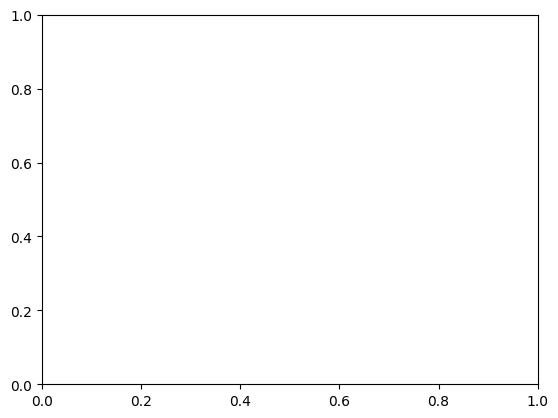

interactive(children=(Text(value='$t$ (s)', description='xlabel'), Text(value='$I$ (A)', description='ylabel')…

In [14]:
ca=Chronoamperometry(e_chem=e_chem,experiment_list=[3],current_density=False)
ca.end_value_fit()
#ca.plot()

In [4]:
import ipywidgets as widgets
from IPython.display import display

reference_values = {
    "SHE": 0,
    "RHE": -0.059,
    "Calomel (sat. KCl)": 0.241,
    "Calomel (3.5 M KCl)": 0.250,
    "Calomel (1 M KCl)": 0.280,
    "Calomel (0.1 M KCl)": 0.334,
    "Ag/AgCl (sat. KCl)": 0.199,
    "Ag/AgCl (3.5 M KCl)": 0.205,
    "Hg/HgO (1 M KOH)": 0.140,
    "Hg/HgO (0.1 M KOH)": 0.165,
    "Fc/Fc+": 0.400
}

@widgets.interact(x=list(reference_values.keys()), y=list(reference_values.keys()), pH="1", potential="0")
def display_widget(x, y, pH, potential):
    global result
    if x == "RHE" or y == "RHE":
        reference_values["RHE"] = -0.0592 * float(pH)
    result = float(potential) + reference_values[y] - reference_values[x]
    print(result)
    return result

test = display_widget



interactive(children=(Dropdown(description='x', options=('SHE', 'RHE', 'Calomel (sat. KCl)', 'Calomel (3.5 M K…

In [27]:
analysis=Analysis()
#analysis.reference_list()
analysis.reference_difference()


interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

In [9]:
print(analysis.reference_difference_value)

-0.334


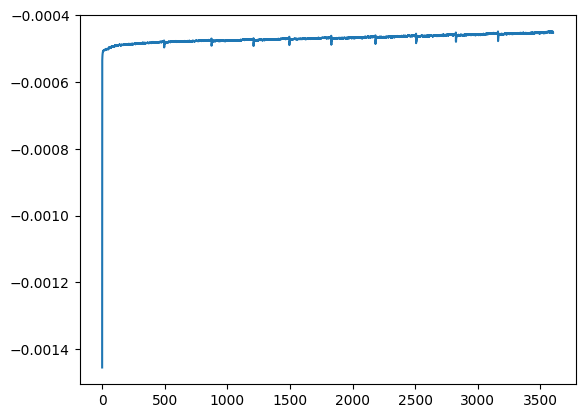

In [11]:

df=pd.read_csv("data/CA_Sarkar.txt",header=0,sep=";",decimal=',',usecols=[0,2],names=["t","I"])
plt.plot(df["t"],df["I"])
plt.show()


In [9]:
print(a)

  

-0.199


In [2]:
test=Analysis()
test.reference_difference()



interactive(children=(Dropdown(description='old_reference', index=6, options=('SHE', 'RHE', 'Calomel (sat. KCl…

In [3]:
test.reference_difference_value

0.08100000000000002

In [15]:
#cv=CyclicVoltammetry(e_chem,[5],[1])

interactive(children=(Text(value='Title', description='title'), Text(value='y label', description='y_label'), …

<function __main__.update_plot(title='Title', y_label='y label', x_value=(0, 10, 0.1), save=False)>

NameError: name 'x_value' is not defined